<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/vae/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder (AE)

Variational Autoencoder (VAE) を理解するために、まず Autoencoder (AE) を実装してみましょう。

CIFAR-10 の画像データセット（28x28 ピクセルの画像）について、エンコーダによって低次元表現に変換し、それをデコーダによって復元します。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# データセットの変換処理
transform = transforms.Compose([
    transforms.ToTensor(),  # 画像をPyTorchのTensorに変換
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 正規化
])

# CIFAR-10のトレーニングデータセット
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# CIFAR-10のテストデータセット
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # エンコーダーの定義
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # [batch, 16, 16, 16]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [batch, 32, 8, 8]
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # [batch, 64, 2, 2]
        )

        # デコーダーの定義
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # [batch, 32, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # [batch, 3, 32, 32]
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x) # エンコーダ
        # この時点における z が低次元表現
        x_prime = self.decoder(z) # デコーダ
        return x_prime


In [4]:
# モデル、損失関数、最適化アルゴリズムの設定
model = Autoencoder().cuda()  # CUDAを使用している場合
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 訓練ループ
num_epochs = 10
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = img.cuda()  # CUDAを使用している場合
        # 順伝播
        output = model(img)
        loss = criterion(output, img)

        # 逆伝播と最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0243
Epoch [2/10], Loss: 0.0212
Epoch [3/10], Loss: 0.0166
Epoch [4/10], Loss: 0.0125
Epoch [5/10], Loss: 0.0154
Epoch [6/10], Loss: 0.0128
Epoch [7/10], Loss: 0.0120
Epoch [8/10], Loss: 0.0118
Epoch [9/10], Loss: 0.0105
Epoch [10/10], Loss: 0.0121


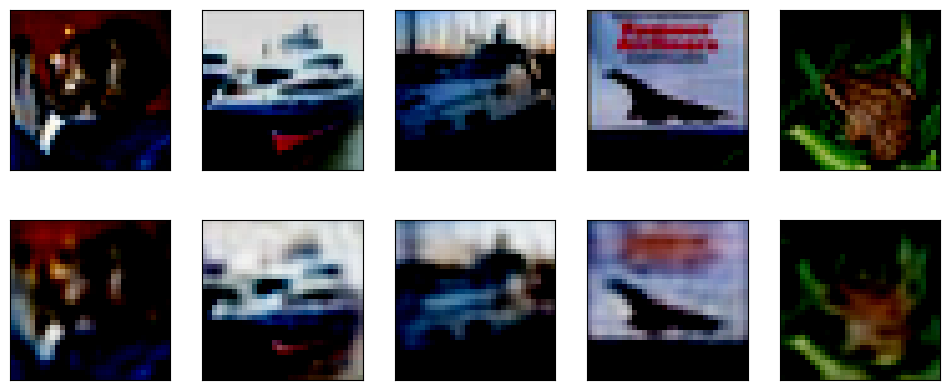

In [5]:
# 訓練が終わったら、いくつかの画像でどのように動作するかを確認
dataiter = iter(testloader)
images, labels = next(dataiter)

output = model(images.cuda())  # CUDAを使用している場合
images = images.numpy()
output = output.detach().cpu().numpy()

# 元の画像と再構成された画像を表示
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12,5))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)